In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from datetime import datetime

def log(message):
    print(datetime.now().strftime("%H:%M:%S -"), message)
    
def printnow():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)

In [3]:
# Create the dictionary of dataframes for training and testing
section_headers = ['Intro','Verse','Refrain','Pre-Chorus','Chorus','Post-Chorus','Hooks','Riffs/Basslines','Scratches','Sampling','Bridge','Interlude','Skit','Collision','Instrumental','Solo','Ad-lib','Segue','Outro']
header_strip_list = '|'.join(['\[' + header + '\]' for header in section_headers])

def header_to_filename(train, header):
    if train: return 'section_train_test/train_' + header.replace('/', '_').lower() + '.zip'
    else: return 'section_train_test/test_' + header.replace('/', '_').lower() + '.zip'

log('Reading data from files')
train_dfs = {header:pd.read_pickle(header_to_filename(1, header)) for header in section_headers}
test_dfs = {header:pd.read_pickle(header_to_filename(0, header)) for header in section_headers}
log('Done\n')

# For dataframes without samples of each genre, add the empty string as lyrics for all genres
dummy_df = pd.DataFrame(data={'lyrics' : 8*[''], 'genre' : 2*['country', 'hiphop', 'pop', 'rock']})
for header in section_headers:
    if len(train_dfs[header]) < 5: train_dfs[header] = pd.concat([train_dfs[header], dummy_df])
    if len(test_dfs[header]) < 5: test_dfs[header] = pd.concat([test_dfs[header], dummy_df])
    train_dfs[header] = train_dfs[header].reset_index(drop=True)
    test_dfs[header] = test_dfs[header].reset_index(drop=True)


21:09:11 - Reading data from files
21:09:11 - Done



In [4]:
log('Finding the counts of each section type in the corpus')
total_length = 0
for i,header in enumerate(section_headers):
    length = len(train_dfs[header]) + len(test_dfs[header])
    print(i + 1, header + ':', length)
    total_length += len(train_dfs[header]) + len(test_dfs[header])
log(f'Done: total length is {total_length}\n')

log('Finding the percent frequencies of each section type in the corpus')
corpus_weights = {}
for i,header in enumerate(section_headers):
    frequency = (len(train_dfs[header]) + len(test_dfs[header])) / total_length
    print(i + 1, header + ':', frequency)
    corpus_weights[header] = frequency
log('Done\n')


21:09:11 - Finding the counts of each section type in the corpus
1 Intro: 1056
2 Verse: 11248
3 Refrain: 438
4 Pre-Chorus: 4128
5 Chorus: 13602
6 Post-Chorus: 1029
7 Hooks: 16
8 Riffs/Basslines: 16
9 Scratches: 16
10 Sampling: 16
11 Bridge: 3417
12 Interlude: 259
13 Skit: 17
14 Collision: 18
15 Instrumental: 190
16 Solo: 177
17 Ad-lib: 19
18 Segue: 16
19 Outro: 2332
21:09:11 - Done: total length is 38010

21:09:11 - Finding the percent frequencies of each section type in the corpus
1 Intro: 0.027782162588792424
2 Verse: 0.2959221257563799
3 Refrain: 0.011523283346487766
4 Pre-Chorus: 0.10860299921073402
5 Chorus: 0.3578531965272297
6 Post-Chorus: 0.02707182320441989
7 Hooks: 0.0004209418574059458
8 Riffs/Basslines: 0.0004209418574059458
9 Scratches: 0.0004209418574059458
10 Sampling: 0.0004209418574059458
11 Bridge: 0.0898973954222573
12 Interlude: 0.006813996316758748
13 Skit: 0.00044725072349381743
14 Collision: 0.00047355958958168905
15 Instrumental: 0.004998684556695606
16 Solo: 0.

In [5]:
#get one array of sections 
train_arr = [lyric for df in train_dfs.values() for lyric in df['lyrics']]

vectorizer_OH = CountVectorizer(min_df = 3, stop_words = 'english')
vectorizer_OH.fit(train_arr)
vocab_size = len(vectorizer_OH.get_feature_names())

In [6]:
# Create TFIDF up to trigram encoding for nonredundant data
def encode_OH(df): 
    #vocab_length = len(vectorizer_OH.get_feature_names())
    encoding_OH = vectorizer_OH.transform(df['lyrics'].values)
    df_OH = pd.DataFrame(encoding_OH.toarray())
    df_OH['y'] = df['genre']
    return df_OH

# Create the training and testing encoded dataframes
log('Encoding the training data')
train_OH = {header:encode_OH(train_dfs[header]) for header in section_headers}
log('Done\n')

log('Encoding the testing data')
test_OH = {header:encode_OH(test_dfs[header]) for header in section_headers}
log('Done\n')


21:09:34 - Encoding the training data
21:09:35 - Done

21:09:35 - Encoding the testing data
21:09:35 - Done



In [66]:
# Load the string lyrics data to make predictions
log('Loading the raw string data')
string_train = pd.read_pickle(r'train_test_data/train.zip')
string_test = pd.read_pickle(r'train_test_data/test.zip')
log('Done\n')

# splits the given lyrics by section 
def split_by_section(lyrics):
    headers = [word[1:-1] for word in lyrics.split() if word[0] == '[' and word[-1] == ']' and word[1:-1] in section_headers]
    split_sections = re.split(header_strip_list, lyrics)
    ret_sections = []
    for section in split_sections:
        mod_section = section.replace('[END]','').replace('[START]','').strip()
        if not(mod_section in ['', ' ','\n']): ret_sections.append(mod_section)
    return list(zip(headers, ret_sections))

# Turn the raw string data into tuples of section strings and the lyrics of that section
log('Splitting the raw string data')
split_string_train = string_train
split_string_train['lyrics'] = string_train['lyrics'].map(split_by_section)
split_string_test = string_test
split_string_test['lyrics'] = string_test['lyrics'].map(split_by_section)
log('Done\n')


01:36:26 - Loading the raw string data
01:36:26 - Done

01:36:26 - Splitting the raw string data
01:36:26 - Done



In [69]:
# Encode the split string data with TFIDF (up to trigrams) and SVD 
def split_lyrics_encode(split_lyrics):
    sections_array = [section for section,lyrics in split_lyrics]
    lyrics_array = [lyrics + ' ' for section,lyrics in split_lyrics]
    try:
        vec_OH = vectorizer_OH.transform(lyrics_array).toarray()
        assert len(vec_OH) == len(sections_array)
        assert len(vec_OH[0]) == vocab_size
        return list(zip(sections_array, vec_OH))
    except IndexError:
        log('ValueError' + str(len(sections_array)) + '\t' + str([len(lyrics) for lyrics in lyrics_array]))
        return list(zip(sections_array, np.array([[0]*vocab_size]*len(split_lyrics))))

# Turn the split string data into tuples of section strings and TFIDF encoded lyrics of that section
log('Splitting the encoding string lyrics of each section')
log('\tTesting set')
split_encoded_test = split_string_test
split_encoded_test['lyrics'] = split_string_test['lyrics'].map(split_lyrics_encode)
log('\tTraining set')
split_encoded_train = split_string_train
split_encoded_train['lyrics'] = split_string_train['lyrics'].map(split_lyrics_encode)
log('Done\n')

01:36:34 - Splitting the encoding string lyrics of each section
01:36:34 - 	Testing set
01:36:35 - 	Training set
01:36:36 - ValueError0	[]
01:36:36 - ValueError0	[]
01:36:38 - ValueError0	[]
01:36:38 - ValueError0	[]
01:36:38 - Done



In [70]:
log('Saving split encoded lyrics as pickles')
split_encoded_train.to_pickle('section_train_test/OH_encoded_train.zip')
split_encoded_test.to_pickle('section_train_test/OH_encoded_test.zip')
log('Done\n')


01:37:18 - Saving split encoded lyrics as pickles
01:38:07 - Done



In [7]:
log('Reading split encoded lyrics pickles into dataframes')
split_encoded_train = pd.read_pickle('section_train_test/OH_encoded_train.zip')
split_encoded_test = pd.read_pickle('section_train_test/OH_encoded_test.zip')
log('Done\n')


21:09:44 - Reading split encoded lyrics pickles into dataframes
21:11:27 - Done



In [15]:
class SectionSplitClassifier:
    def __init__(self, section_classifiers, weights):
        if section_classifiers:
            try: self.section_classifiers = {key:value for key,value in section_classifiers.items()}
            except AttributeError: raise ValueError('section_classifiers was not a dictionary')
        else: raise ValueError('section_classifiers was None')
        if weights:
            if np.round(np.sum([weight for weight in weights.values()])) == 1:
                try: self.weights = {key:value for key,value in weights.items()}
                except AttributeError: raise ValueError('weights was not a dictionary')
            else: raise ValueError('weights did not sum to 1')
        else: raise ValueError('weights was None')


    def set_section_classifiers(self, section_classifiers):
        if section_classifiers:
            try: self.section_classifiers = {key:value for key,value in section_classifiers.items()}
            except AttributeError: raise ValueError('section_classifiers was not a dictionary')
        else: raise ValueError('section_classifiers was None')


    def set_weights(self, weights):
        if weights:
            if np.round(np.sum([weight for weight in weights.values()])) == 1:
                try: self.weights = {key:value for key,value in weights.items()}
                except AttributeError: raise ValueError('weights was not a dictionary')
            else: raise ValueError('weights did not sum to 1')
        else: raise ValueError('weights was None')


    def fit(self, X, y, section, verbose=0, keras=0):
        if verbose: print(f'Training {section}...')
        if keras:
            history = self.section_classifiers[section].fit(X,y)
        else:
            self.section_classifiers[section] = self.section_classifiers[section].fit(X,y)
        if verbose: print(f'Done training {section}')


    def predict(self, X, keras=0):
        def predict_section(self, X_section, section, keras=0):
            def str_to_array(string, weight):
                return float(weight) * np.array([
                    int(string == 'country'), 
                    int(string == 'hiphop'),
                    int(string == 'pop'), 
                    int(string == 'rock')])
            if keras:
                return [str_to_array(pred, self.weights[section]) for pred in self.section_classifiers[section].predict([X_section])]
            else:
                return [str_to_array(pred, self.weights[section]) for pred in self.section_classifiers[section].predict(np.reshape(X_section, (-1,500)))]

        def predict_song(self, split_encoded, keras=0):
            def array_to_str(array):
                return ['country','hiphop','pop','rock'][np.argmax(array)]
            pred = np.array([0,0,0,0])
            for section,encoding in split_encoded:
                pred = np.sum([pred, predict_section(self, encoding, section, keras=keras)], axis=0)
            return array_to_str(pred)

        preds = [predict_song(self, lyrics) for lyrics in X]
        assert len(preds) == len(X)
        return(preds)



In [22]:
# create the different kinds of section classifiers and their respective song classifiers
section_rf_classifiers = {
    header:RandomForestClassifier(criterion='entropy', ccp_alpha=0.0175) for header in section_headers}
section_rf_classifier = SectionSplitClassifier(section_rf_classifiers, corpus_weights)

section_ada_classifiers = {
    header:OneVsRestClassifier(AdaBoostClassifier(), n_jobs=-1) for header in section_headers}
section_ada_classifier = SectionSplitClassifier(section_ada_classifiers, corpus_weights)

section_svm_classifiers = {
    header:OneVsRestClassifier(SVC(kernel="linear", C=0.025), n_jobs=-1) for header in section_headers}
section_svm_classifier = SectionSplitClassifier(section_svm_classifiers, corpus_weights)

section_knn_classifiers = {
    header:OneVsOneClassifier(KNeighborsClassifier(3)) for header in section_headers}
section_knn_classifier = SectionSplitClassifier(section_knn_classifiers, corpus_weights)

# define baseline Keras neuralnet model
def baseline_model(input_dim):
	# create model
	model = Sequential()
	model.add(Dense(int(input_dim/2), input_dim=input_dim, activation='relu'))
	model.add(Dense(50, activation='relu'))
	model.add(Dense(4, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

from keras.

section_net_classifiers = {
    header:KerasClassifier(build_fn=baseline_model, input_dim=8642, epochs=20, batch_size=100, verbose=0) for header in section_headers}
section_net_classifier = SectionSplitClassifier(section_net_classifiers, corpus_weights)

Instructions for updating:
Colocations handled automatically by placer.


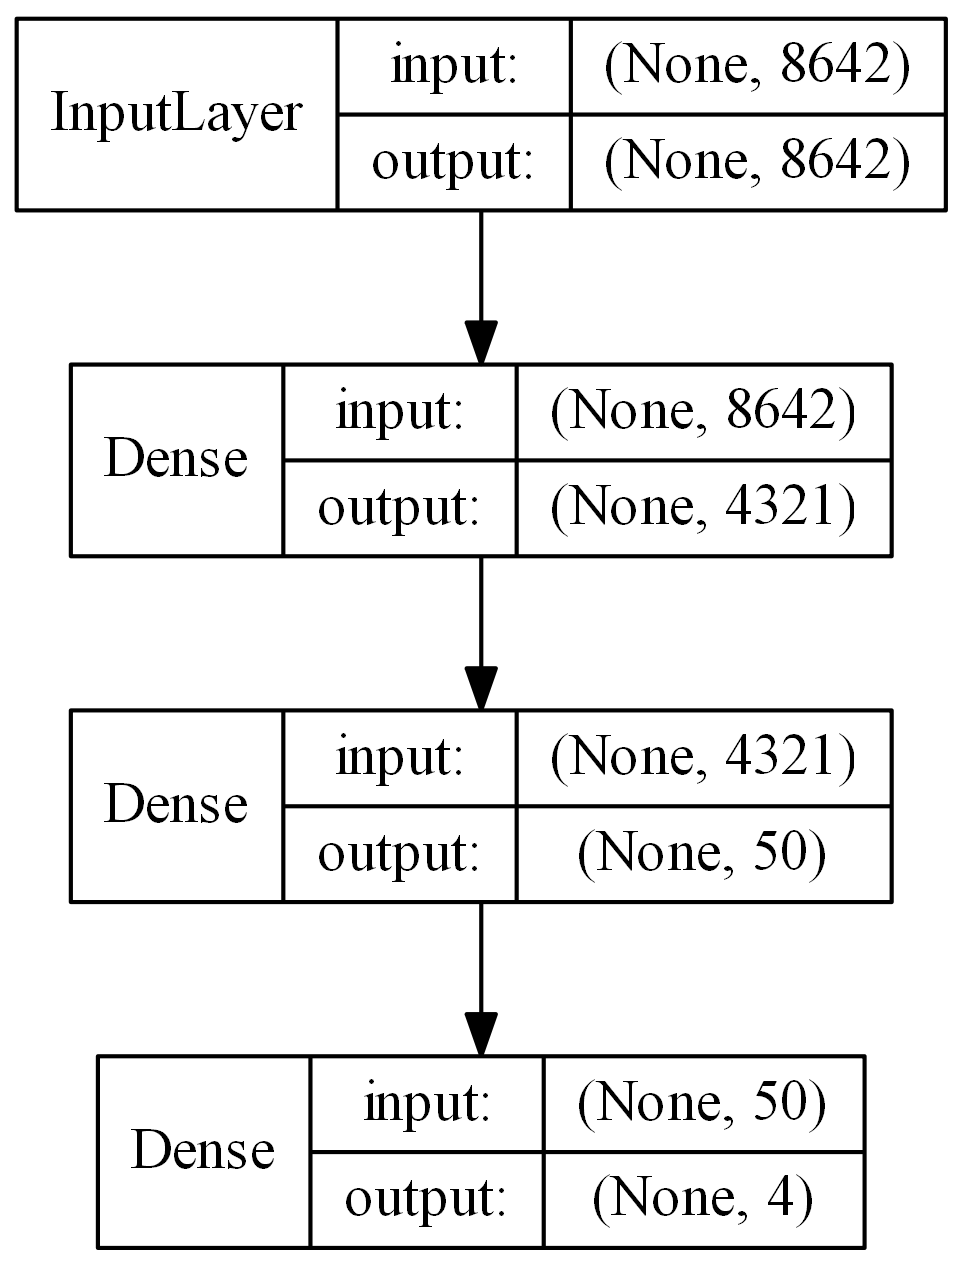

In [3]:
from keras.utils import plot_model
plot_model(baseline_model(8642), to_file='onehot_nn_image.png', show_shapes=True, show_layer_names=False, expand_nested=True, dpi=300)

In [21]:
# train each kind of song classifier
# log('Training Random Forest classifier with all sections')
# for header in section_headers:
#     section_rf_classifier.fit(train_OH[header].drop(columns=['y']), train_OH[header]['y'], header, verbose=0)
# log('Done\n')

# log('Training ADA Boost classifier with all sections')
# for header in section_headers:
#     section_ada_classifier.fit(train_OH[header].drop(columns=['y']), train_OH[header]['y'], header, verbose=0)
# log('Done\n')

# log('Training Linear SVM classifier with all sections')
# for header in section_headers:
#     section_svm_classifier.fit(train_OH[header]s.drop(columns=['y']), train_OH[header]['y'], header, verbose=0)
# log('Done\n')

# log('Training k-Nearest Neighbors classifier with all sections')
# for header in section_headers:
#     section_knn_classifier.fit(train_OH[header].drop(columns=['y']), train_OH[header]['y'], header, verbose=0)
# log('Done\n')

log('Training Neural Net classifier with all sections')
for header in section_headers:
    section_net_classifier.fit(train_OH[header].drop(columns=['y']), train_OH[header]['y'], header, verbose=1)
log('Done\n')


21:21:32 - Training Neural Net classifier with all sections
Training Intro...
Epoch 1/20
849/849 [==============================] - 6s 7ms/step - loss: 1.3149 - accuracy: 0.3793
Epoch 2/20
849/849 [==============================] - 6s 7ms/step - loss: 1.0886 - accuracy: 0.5112
Epoch 3/20
849/849 [==============================] - 6s 7ms/step - loss: 0.9144 - accuracy: 0.5795
Epoch 4/20
600/849 [====================>.........] - ETA: 1s - loss: 0.7934 - accuracy: 0.6083

KeyboardInterrupt: 

In [ ]:
def predict_write_results(filename, classifier_name, classifier, X_train, X_test, verbose=1):
    results_file = open(filename, 'a')
    if verbose: log(f'Predicting results for {classifier_name}')
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    if verbose: log('Done\n')

    if verbose:
        print(f'Training Set Accuracy: {accuracy_score(split_encoded_train["genre"], y_pred_train)}')
        print(f'Classification Report Training Set:\n{classification_report(split_encoded_train["genre"], y_pred_train)}')
        print(f'Confusion Matrix Training Set:\n{confusion_matrix(split_encoded_train["genre"], y_pred_train)}\n')
        print(f'Testing Set Accuracy: {accuracy_score(split_encoded_test["genre"], y_pred_test)}')
        print(f'Classification Report Testing Set:\n{classification_report(split_encoded_test["genre"], y_pred_test)}')
        print(f'Confusion Matrix Testing Set:\n{confusion_matrix(split_encoded_test["genre"], y_pred_test)}\n')

    results_file.write(f'Results for {classifier_name}\n')
    results_file.write(f'Training Set Accuracy: {accuracy_score(split_encoded_train["genre"], y_pred_train)}\n')
    results_file.write(f'Classification Report Training Set:\n{classification_report(split_encoded_train["genre"], y_pred_train)}')
    results_file.write(f'Confusion Matrix Training Set:\n{confusion_matrix(split_encoded_train["genre"], y_pred_train)}\n')
    results_file.write(f'Testing Set Accuracy: {accuracy_score(split_encoded_test["genre"], y_pred_test)}\n')
    results_file.write(f'Classification Report Testing Set:\n{classification_report(split_encoded_test["genre"], y_pred_test)}')
    results_file.write(f'Confusion Matrix Testing Set:\n{confusion_matrix(split_encoded_test["genre"], y_pred_test)}\n')
    results_file.write(str('-' * 30) + '\n')
    results_file.close()

    return y_pred_train, y_pred_test


In [ ]:
log('start')
y_pred_train_net, y_pred_test_net = predict_write_results('eval_onehot_section.txt', 'Neural Net Classifier', section_net_classifier, split_encoded_train['lyrics'], split_encoded_test['lyrics'], verbose=1)
log('net prediction done')

In [87]:
# predict the genres of both training and testing sets
log('start')
y_pred_train_rf = section_rf_classifier.predict(split_encoded_train['lyrics'])
y_pred_test_rf = section_rf_classifier.predict(split_encoded_test['lyrics'])
log('rf prediction done')
y_pred_train_ada = section_ada_classifier.predict(split_encoded_train['lyrics'])
y_pred_test_ada = section_ada_classifier.predict(split_encoded_test['lyrics'])
log('ada prediction done')
y_pred_train_svm = section_svm_classifier.predict(split_encoded_train['lyrics'])
y_pred_test_svm = section_svm_classifier.predict(split_encoded_test['lyrics'])
log('svm prediction done')
y_pred_train_knn = section_knn_classifier.predict(split_encoded_train['lyrics'])
y_pred_test_knn = section_knn_classifier.predict(split_encoded_test['lyrics'])
log('knn prediction done')

02:53:29 - start
02:59:29 - rf prediction done
04:08:51 - ada prediction done
05:51:27 - svm prediction done
11:10:01 - knn prediction done


In [88]:
def show_results(y_pred_train, y_pred_test):
    print(f'Training Set Accuracy: {accuracy_score(split_encoded_train["genre"], y_pred_train)}')
    print(f'Classification Report Training Set:\n{classification_report(split_encoded_train["genre"], y_pred_train)}')
    print('-' * 20)
    print(f'Confusion Matrix Training Set:\n{confusion_matrix(split_encoded_train["genre"], y_pred_train)}\n')
    
    print(f'Testing Set Accuracy: {accuracy_score(split_encoded_test["genre"], y_pred_test)}')
    print(f'Classification Report Testing Set:\n{classification_report(split_encoded_test["genre"], y_pred_test)}')
    print('-' * 20)
    print(f'Confusion Matrix Testing Set:\n{confusion_matrix(split_encoded_test["genre"], y_pred_test)}\n')

y_pred_trains = [y_pred_train_rf, y_pred_train_ada, y_pred_train_svm, y_pred_train_knn]
y_pred_tests = [y_pred_test_rf, y_pred_test_ada, y_pred_test_svm, y_pred_test_knn]

for train, test in zip(y_pred_trains, y_pred_tests):
    show_results(train, test)

Training Set Accuracy: 0.28683943089430897
Classification Report Training Set:
              precision    recall  f1-score   support

     country       0.00      0.00      0.00       738
      hiphop       0.29      1.00      0.45      1131
         pop       0.00      0.00      0.00       973
        rock       0.00      0.00      0.00      1094

    accuracy                           0.29      3936
   macro avg       0.07      0.25      0.11      3936
weighted avg       0.08      0.29      0.13      3936

--------------------
Confusion Matrix Training Set:
[[   0  738    0    0]
 [   2 1129    0    0]
 [   0  972    0    1]
 [   2 1092    0    0]]

Testing Set Accuracy: 0.25888324873096447
Classification Report Testing Set:
              precision    recall  f1-score   support

     country       0.00      0.00      0.00       199
      hiphop       0.26      1.00      0.41       255
         pop       0.00      0.00      0.00       239
        rock       0.00      0.00      0.00   